# Preprocessing

In [2]:
import pandas as pd
df = pd.read_csv("data/train.csv")
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [3]:
print('Strict duplicates: ', df[df.duplicated()].size)

duplicated_text_rows = df[df.duplicated(['text'])]
print('Description duplicates: ', duplicated_text_rows.text.unique().size)
print('Number of duplicates with conflicting labels: ', duplicated_text_rows.apply(lambda onerow: df[onerow.text == df.text].target.unique().size == 1, axis='columns').value_counts()[False])

Strict duplicates:  0
Description duplicates:  69
Number of duplicates with conflicting labels:  37


In [4]:
n_removed = df.shape[0]-df.drop_duplicates(['text']).shape[0]
print('Number of dropped duplicate rows: ', n_removed)
print('As a percentage of total data: %.2f%%' % (float(n_removed)/df.shape[0]*100))
df = df.drop_duplicates(['text'])

Number of dropped duplicate rows:  110
As a percentage of total data: 1.44%


# NLP on tweets - basics

Set up the required imports, and load the data:

## Tailor the NLP pipeline to our purposes

Useful for reference:
* [rule-based matching](https://spacy.io/usage/rule-based-matching)
* [pipelines](https://spacy.io/usage/processing-pipelines)

Load up the base pipeline:

In [5]:
import spacy as spc
from spacy import displacy as dsp
nlp = spc.load("en_core_web_sm")

The first step is to make sure that '@' and '#' get the same treatment. By default, '@' is considered a part of a token, and '#' is considered its own token. So, make sure that they are considered individual tokens, to make processing easier in later parts.

In [6]:
prefixes = nlp.Defaults.prefixes + (r'@',r'#')
prefix_regex = spc.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

So, this is what the tokenizer does now:

In [7]:
for tok in nlp("@username text #hashtag"):
    print(tok)
    

@
username
text
#
hashtag


Next, define the part of the pipeline that combines the '@' and '#' symbols, followed by alphanumerics, into a single token:

In [8]:
def retokenize_pipe(doc):
    with doc.retokenize() as retokenizer:
        for tok in doc:
            if not tok.i == len(doc)-1:
                if (tok.text == '#' or tok.text == '@') and not (doc[tok.i+1].text == '#' or doc[tok.i+1].text == '@') and not bool(tok.whitespace_):
                    retokenizer.merge(doc[tok.i:tok.i+2])
                elif tok.text == '&' and not bool(tok.whitespace_) and not tok.i == len(doc)-1 and not '&' in [t.text for t in doc[tok.i+1:tok.i+3]]:
                    retokenizer.merge(doc[tok.i:tok.i+3])
    return doc

In some cases, the tweets contain HTML entities. Some should be replaced with their equivalent words like ('&' to 'and'), others should be removed/

In [9]:
def handle_htmlents_pipe(doc):
    replacements = {
        '&amp;': 'and',
        '&deg;': 'degrees'
    }
    words = []
    has_space = []
    for t in doc:
        if t.text.startswith('&') and t.text.endswith(';'):
            if t.text in replacements:
                words.append(replacements[t.text])
                has_space.append(t.whitespace_)
        else:
            words.append(t.text)
            has_space.append(t.whitespace_)

    
    return spc.tokens.Doc(doc.vocab, words=words, spaces=has_space)

Certain mentions should be treated as special, i.e. if they mention an account belonging to a news/disaster relief organisation. The presence of such a handle would be a strong indicator of the tweet being about a disaster.

In [10]:
from json import load
with open('twitter_handles.json') as f:
    twitter_handles = load(f)

is_news_mention = lambda t: t.text.startswith('@') and t.text[1:].lower() in twitter_handles['news']
is_relief_mention = lambda t: t.text.startswith('@') and t.text[1:].lower() in twitter_handles['relief']
spc.tokens.Token.set_extension("is_news_mention", getter=is_news_mention, force=True)
spc.tokens.Token.set_extension("is_relief_mention", getter=is_relief_mention, force=True)

The extensions set above can be called with e.g. `Token._.is_news_mention`, they're not pipeline components. `force=True` is set because Jupyter would complain.

Then, the part of the pipeline which takes a '@xxxx' or '#xxx' symbol and marks it as the correct entity. Also marks links as link entities.

In [11]:
def entity_pipe(nlp):
    ruler = nlp.create_pipe("entity_ruler")
    
    patterns = [
        {"label": "HASHTAG", "pattern": [{"TEXT": {"REGEX": r'^#\w+'}}]},
        {"label": "LINK", "pattern": [{"TEXT": {"REGEX": r'https?://.*'}}]},
        {"label": "NEWS-ORG", "pattern": [{"_": {"is_news_mention": True}}]},
        {"label": "RELIEF-ORG", "pattern": [{"_": {"is_relief_mention": True}}]},
        {"label": "MENTION", "pattern": [{"TEXT": {"REGEX": r'^@\w+'}, "_": {"is_news_mention": False, "is_relief_mention": False}}]}
    ]
    
    ruler.add_patterns(patterns)
    return ruler

Some tweets include abbreviations, and these may get incorrectly classified by the default tools. This part of the pipeline should fix that.

In [12]:
def abbr_handler(nlp):
    ruler = nlp.create_pipe("entity_ruler")
    patterns = [
        {"label": "ORG", "pattern": [{"LOWER": {"REGEX": r'e\.?r\.?'}}]},
        {"label": "ORG", "pattern": [{"LOWER": "emergency"}, {"LOWER": "room"}]},
        {"label": "ORG", "pattern": [{"LOWER": "emergency"}, {"LOWER": "relief"}]}
    ]
    ruler.add_patterns(patterns)
    return ruler

Insert the functions into the NLP pipeline. The tokenizer is the first thing that runs (implicitly, it's not visible in the pipeline), so the token combiner function should be the first thing in the pipeline. The entity ruler should go before the named entity recogniser, as we want the NER to recognise anything that our custom ruler doesn't recognise, not the other way around.

In [13]:
nlp.add_pipe(retokenize_pipe, name="retokenizer", first=True)
nlp.add_pipe(handle_htmlents_pipe, name="html_ent_handler", after='retokenizer')
nlp.add_pipe(entity_pipe(nlp), name="entruler", before='ner')
nlp.add_pipe(abbr_handler(nlp), name="abbr_handler", after='ner')

The current pipeline looks like this:

In [14]:
nlp.pipeline

[('retokenizer', <function __main__.retokenize_pipe(doc)>),
 ('html_ent_handler', <function __main__.handle_htmlents_pipe(doc)>),
 ('tagger', <spacy.pipeline.pipes.Tagger at 0x115b97410>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x1157c6c90>),
 ('entruler', <spacy.pipeline.entityruler.EntityRuler at 0x11de18910>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x115a53ec0>),
 ('abbr_handler', <spacy.pipeline.entityruler.EntityRuler at 0x11de189d0>)]

## Execute the pipeline

Now, run the pipeline on a random tweet:

In [15]:
random_tweet = df.sample().iloc[0].text
doc = nlp(random_tweet)

The tweet has been tokenized, but not all tokens are useful. In particular, stop words and punctuation are useless for us, so `is_token_allowed` will filter those out:

In [16]:
def is_token_allowed(token):
    return (token and token.string.strip() and not token.is_stop and not token.is_punct)

We also only want some entities:

In [17]:
def is_entity_allowed(entity):
    wanted = ['NEWS-ORG', 'RELIEF-ORG', 'HASHTAG', 'ORG', 'GPE', 'FAC']
    return entity.label_ in wanted

Also, all tokens should be converted to their lowercase, lemmatized form.
So, define two hashes containing the results from the processed doc:

In [18]:
useful_tokens = [{'token': token.lemma_.strip().lower(), 'pos': token.pos_, 'dep': token.dep_, 'ent': token.ent_type_} for token in doc if is_token_allowed(token)]
useful_entities = [{'text': ent.text, 'label': ent.label_} for ent in doc.ents if is_entity_allowed(ent)]

Extract tokens with specific properties to get the general idea of the sentence:

In [19]:
def extract_sov(toks):
    subjects = list({t['token'] for t in toks if t['dep'] in ['nsubj', 'nsubjpass'] and t['ent'] not in ['LINK', 'MENTION', 'HASHTAG', 'RELIEF-ORG', 'NEWS-ORG']})
    objects = list({t['token'] for t in toks if t['dep'] in ['dobj, obj, pobj'] and t['ent'] not in ['LINK', 'MENTION', 'HASHTAG', 'RELIEF-ORG', 'NEWS-ORG']})
    verbs = list({t['token'] for t in toks if t['pos'] in ['VERB'] and t['ent'] not in ['LINK', 'MENTION', 'HASHTAG', 'RELIEF-ORG', 'NEWS-ORG']})

    return subjects, objects, verbs

## See the results

Finally, print out the results:

In [20]:
# id, keyword, location, text, hashtag, subj, verb, object, news org (bool), relief org (bool), org, gpe, fac
df_out = pd.DataFrame(columns=['id', 'keyword', 'location', 'text', 'hashtag', 'subj', 'verb', 'obj', 'contains_synonym', 'mentioned_news_org', 'mentioned_relief_org', 'mentions', 'orgs', 'gpes', 'facs', 'target'])
for i, twit in df.iterrows():
    doc = nlp(twit.text)
    useful_tokens = [{'token': token.lemma_.strip().lower(), 'pos': token.pos_, 'dep': token.dep_, 'ent': token.ent_type_} for token in doc if is_token_allowed(token)]
    useful_entities = [{'text': ent.text, 'label': ent.label_} for ent in doc.ents if is_entity_allowed(ent)]
    
    hashtags = [ent['text'] for ent in useful_entities if ent['label'] == 'HASHTAG']
    mentioned_news = bool([ent for ent in useful_entities if ent['label'] == 'NEWS-ORG'])
    mentioned_relief = bool([ent for ent in useful_entities if ent['label'] == 'RELIEF-ORG'])
    orgs = [ent['text'] for ent in useful_entities if ent['label'] == 'ORG']
    gpes = [ent['text'] for ent in useful_entities if ent['label'] == 'GPE']
    facs = [ent['text'] for ent in useful_entities if ent['label'] == 'FAC']
    mentions = [x.text for x in doc.ents if x.label_ == 'MENTION']
    subjs, objs, verbs = extract_sov(useful_tokens)
    
    synonyms = {'accident', 'calamity', 'catastrophe', 'collapse', 'crash', 'debacle', 'defeat', 'emergency', 'failure', 'fiasco', 'flood', 'harm', 'hazard', 'holocaust', 'mishap', 'setback', 'tragedy', 'woe', 'adversity', 'affliction', 'bale', 'bane', 'blight', 'blow', 'bust', 'casualty', 'cataclysm', 'collision', 'depression', 'exigency', 'fall', 'flop', 'grief', 'misadventure', 'mischance', 'misfortune', 'reverse', 'rock', 'rough', 'ruin', 'ruination', 'slip', 'stroke', 'undoing', 'upset', 'washout', 'act of God', 'bad luck', 'bad news', 'fell stroke', 'hard luck', 'hot water', 'ill luck', 'the worst'}
    contains_synonym = len(synonyms.intersection({x.lower() for x in twit.text.split(' ')})) > 0

    df_out.loc[i] = {
        'id': twit.id,
        'keyword': twit.keyword,
        'location': twit.location,
        'text': twit.text,
        'hashtag': hashtags,
        'subj': subjs,
        'verb': verbs,
        'obj': objs,
        'mentioned_news_org': mentioned_news,
        'mentioned_relief_org': mentioned_relief,
        'mentions': mentions,
        'contains_synonym': contains_synonym,
        'orgs': orgs,
        'gpes': gpes,
        'facs': facs,
        'target': twit.target
    }

In [21]:
df_out.columns

Index(['id', 'keyword', 'location', 'text', 'hashtag', 'subj', 'verb', 'obj',
       'contains_synonym', 'mentioned_news_org', 'mentioned_relief_org',
       'mentions', 'orgs', 'gpes', 'facs', 'target'],
      dtype='object')

In [22]:
print("Number of rows with null:")
df_out.apply(lambda x: sum(x.isnull()), axis='index')

Number of rows with null:


id                         0
keyword                   56
location                2482
text                       0
hashtag                    0
subj                       0
verb                       0
obj                        0
contains_synonym           0
mentioned_news_org         0
mentioned_relief_org       0
mentions                   0
orgs                       0
gpes                       0
facs                       0
target                     0
dtype: int64

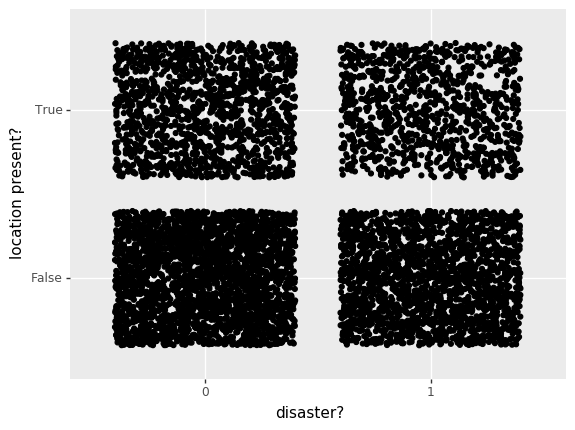

<ggplot: (303932393)>

In [23]:
import plotnine as p9
(p9.ggplot(df_out)
 + p9.aes(x='target', y='location.isnull()')
 + p9.xlab('disaster?')
 + p9.ylab('location present?')
 + p9.geom_jitter())

In [24]:
print("Num mentioned news organisations: ", df_out.mentioned_news_org.value_counts()[True])
print("Num mentioned relief organisations: ", df_out.mentioned_relief_org.value_counts()[True])
print("Num containing organisation entities: ", df_out.orgs.map(bool).value_counts()[True])
print("Num containing gpe entities: ", df_out.gpes.map(bool).value_counts()[True])
print("Num containing fac entities: ", df_out.facs.map(bool).value_counts()[True])
print("Num containing mentions: ", df_out.mentions.map(bool).value_counts()[True])

Num mentioned news organisations:  5
Num mentioned relief organisations:  3
Num containing organisation entities:  4481
Num containing gpe entities:  1140
Num containing fac entities:  130
Num containing mentions:  1952


# Useful functions

Extract all mentions from the dataframe into a text file for further processing/analyzing:

```python
with open('mentions.txt', "w") as f:
    for i,content in df_out[df_out.mentions.map(bool)].iterrows():
        [f.write("%s\n" % x) for x in content.mentions]
``` 

In [25]:
with open('mentions.txt', "w") as f:
    for i,content in df_out[df_out.mentions.map(bool)].iterrows():
        [f.write("%s\n" % x) for x in content.mentions]